# This spreadsheet calculates size of the pipeline for single gas phase

## Input data
example of a West shetland main line

In [62]:
#exact model from the OC just for reference in the next line we make a simple model for this spreadsheet
import math
import sys
import numpy as np
import colebrook
import json

with open('line.json', "r") as json_file:
    data=json_file.read()
    _line = json.loads(data)


In [63]:
for index, i in enumerate(_line["properties"]):
    print(index, i["name"], i["value"])

0 packingOnReelOrCarousel 
1 od {'value': 0.273, 'unit': 'm'}
2 color 16711680
3 material Carbon Steel
4 smys 448000000.0
5 weight {'value': 100.714, 'unit': 'kg/m'}
6 id {'value': 0.241, 'unit': 'm'}
7 density {'value': 7850, 'unit': 'kg/m^3'}
8 wallThickness {'value': 15.88, 'unit': 'mm'}
9 points [{'x': 0.0, 'y': 0.12, 'z': 54.0546}, {'x': 927.7, 'y': 32758.0, 'z': -99.0}, {'x': -28471.08, 'y': 113337.86, 'z': -704.0}, {'x': -55703.16, 'y': 165663.44, 'z': -1640.0}, {'x': -39675.55, 'y': 171925.05, 'z': -1564.0}]


In [64]:
line = {_line["properties"][1]["name"]: _line["properties"][1]["value"]["value"],
       _line["properties"][4]["name"]: _line["properties"][4]["value"],
       _line["properties"][8]["name"]: _line["properties"][8]["value"]["value"]/1000,
       _line["properties"][9]["name"]: _line["properties"][9]["value"]}
line

{'od': 0.273,
 'smys': 448000000.0,
 'wallThickness': 0.015880000000000002,
 'points': [{'x': 0.0, 'y': 0.12, 'z': 54.0546},
  {'x': 927.7, 'y': 32758.0, 'z': -99.0},
  {'x': -28471.08, 'y': 113337.86, 'z': -704.0},
  {'x': -55703.16, 'y': 165663.44, 'z': -1640.0},
  {'x': -39675.55, 'y': 171925.05, 'z': -1564.0}]}

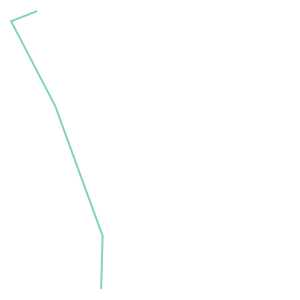

In [65]:
from shapely.geometry import Point, Polygon, LineString
points_list =[(x["x"],x["y"],x["z"]) for x in line["points"]] 
path=LineString(points_list)
path

In [66]:
# adding other needed parameters to the line - this will be put in the line template
line["angle"] = -90
line["length"]= path.length
line["kfPipe"]= 60
line["pipeRoughness"]= 0.0023 
line

{'od': 0.273,
 'smys': 448000000.0,
 'wallThickness': 0.015880000000000002,
 'points': [{'x': 0.0, 'y': 0.12, 'z': 54.0546},
  {'x': 927.7, 'y': 32758.0, 'z': -99.0},
  {'x': -28471.08, 'y': 113337.86, 'z': -704.0},
  {'x': -55703.16, 'y': 165663.44, 'z': -1640.0},
  {'x': -39675.55, 'y': 171925.05, 'z': -1564.0}],
 'angle': -90,
 'length': 194741.37068050078,
 'kfPipe': 60,
 'pipeRoughness': 0.0023}

In [73]:
maxWd = abs(min(map(lambda point: point["z"], line["points"])));
minWd = abs(max(map(lambda point: point["z"], line["points"])));
maxWd, minWd

(1640.0, 54.0546)

In [98]:
def calPressureDrop(fluid, line):
    re=fluid["density"]*velocity*id/fluid["viscosity"];
    pRo = line["pipeRoughness"]
    f = colebrook.sjFriction( re, pRo)
    pressureDrop_unit = -fluid["density"]*9.81*math.sin(line["angle"]*math.pi/180)-f*fluid["density"]*velocity/(2*id)
    pressureDrop = pressureDrop_unit * line["length"]
    pStart = fluid["pressure"]
    pEnd = fluid["pressure"] - pressureDrop
    print(f"Starting pressure is {pStart/10**5} and end is {pEnd/10**5}")
    return pressureDrop_unit

In [103]:
#fluid data
fluid = {
    "temperature": 33,
    "flowRate": 80,
    "pressure": 80*10**5,
    "density": 2.2,
    "viscosity": 200*10e-6,
    "heatCapapcity": 2.31,
    "thermalConductivity": 0.035,
    "Compressibility  Factor": 1,
    "description": ["COMPOSITION onecomponent = ON","library name=\"Methane\" comp=1"]
}
#environment data
oceanEnvironment = {
    0: {"temperature":23, "current":0.7, "waterViscocity":0.9321*10e-6},
    100: {"temperature":13, "current":0.65, "waterViscocity":1.2005*10e-6},
    200: {"temperature":5, "current":0.39, "waterViscocity":1.5182*10e-6},
    1500: {"temperature":3, "current":0.1, "waterViscocity":1.6735*10e-6}
}
owd=[k for k in oceanEnvironment]
print(owd);
otemp = [oceanEnvironment[k]["temperature"] for k in owd]
ovis = [oceanEnvironment[k]["waterViscocity"] for k in owd]

waterViscocity = 1.6735*10e-6;


''' example how to get properies of water'''
from iapws import SeaWater
state = SeaWater(T=300, P=0.101325, S=0.001)    #Seawater with 0.1% Salinity
# print(state.cp)                                 # Get cp

odInch = [4.5,6.625,8.625,10.75,12.75,14,16,18,20,22,24,26,28,30,32,34,36];

for odI in odInch:
    
    od=(25.4*odI)/1000
    id=od-2*line["wallThickness"];
    #calculate velocity
    velocity = math.pow(10,6)/((86400*35.3147)*math.pi/4*math.pow(id,2));
    print(f"For od {odI}in Velocity is {velocity}")
    if velocity > 25:
        print("Velocity too high selecting next bigger od")
        continue;
    
    #calculate pressure drop
    pressureDrop_unit = calPressureDrop(fluid, line)
    if(pressureDrop_unit/100 > 0.25):
        print(f"Pressure drop > 0.25 skipping to next bigger od")
        continue;
    
    #calculate temperature drop

    maxWd = abs(min(map(lambda point: point["z"], line["points"])));
    tExt = np.interp(maxWd, owd, otemp);
    cpFluid = fluid["heatCapapcity"];
    kFluid = fluid["thermalConductivity"];
    pr= fluid["viscosity"]*cpFluid/kFluid;
    print("   Prandtl number is ",pr)
    waterViscosity = np.interp(maxWd, owd, ovis);
    
    nu = 0;
    if re >6000:
        nu = math.pow(0.023*Re, 4/5)*math.pow(pr, 1/3)*math.pow(fluid["viscosity"]/waterViscosity,0.14)
    elif re<2000:
        nu = 1.86*re*pr* math.pow(id/line["length"], 1/3)*math.pow(fluid["viscosity"]/waterViscosity,0.14)
    else: 
        nu6000 = math.pow(0.023*6000, 4/5)*math.pow(pr, 1/3)*math.pow(fluid["viscosity"]/waterViscosity,0.14)
        nu2000 = math.pow(0.023*2000, 4/5)*math.pow(pr, 1/3)*math.pow(fluid["viscosity"]/waterViscosity,0.14)
        
        xp = [2000,6000]
        fp = [nu2000, nu6000]     
        nu = np.interp(re, xp, fp)
        print(f"   For Re= {re} Nu= {nu}. Interpolation of Re=6000 nu={nu6000} and Re=2000 nu={nu2000}")
    print("   Nu = ",nu)
    
    hin=kFluid*nu/id;
    R=  8.3144598
#     ho=hin + u*( tExt - fluid["temperature"])*math.pi*id*line["length"]/flowRate-(Z*R*T*flowRate/(pEnd*MW*id**2/4*PI())) -9.81*delta(elev) 



        
    



[0, 100, 200, 1500]
For od 4.5in Velocity is 61.25082262255811
Velocity too high selecting next bigger od
For od 6.625in Velocity is 22.391341213492215
Starting pressure is 80.0 and end is 53.8874639484655
   Prandtl number is  0.13199999999999998
   For Re= 3362.4293403358784 Nu= 31.481855874527646. Interpolation of Re=6000 nu=51.23866964488336 and Re=2000 nu=21.276532027123206
   Nu =  31.481855874527646
For od 8.625in Velocity is 11.893118377268845
Starting pressure is 80.0 and end is 44.744266098023466
   Prandtl number is  0.13199999999999998
   For Re= 3362.4293403358784 Nu= 31.481855874527646. Interpolation of Re=6000 nu=51.23866964488336 and Re=2000 nu=21.276532027123206
   Nu =  31.481855874527646
For od 10.75in Velocity is 7.167409336087322
Starting pressure is 80.0 and end is 41.40703128537769
   Prandtl number is  0.13199999999999998
   For Re= 3362.4293403358784 Nu= 31.481855874527646. Interpolation of Re=6000 nu=51.23866964488336 and Re=2000 nu=21.276532027123206
   Nu = 